#### 测试 DLS 技术完成同步，并写出并行版本

In [111]:
import os
import sys
sys.path.append(r"../../")
import copy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import pandas as pd
# 自定义
from base_mods import *
from nodes.Lorenz import *
from utils.DLS import *
from connect.BA_scale_free import create_sf_jit, create_sf

In [124]:
np.random.seed(0)
random.seed(0)

In [113]:
N = 100
method = "rk4"
dt = 0.01

# 节点
nodes = Lorenz(N, method, dt)
nodes.vars_nodes = np.random.rand(3, N)

# 拓扑结构
connM = create_sf_jit(n=N, n_init=5, n_add=2, seed=0)
# connM = create_sf(n=N, n_init=5, n_add=2)

w = np.random.uniform(0, 1, (N, N))

In [114]:
# 求解特征值
connM1 = connM*w
degrees = np.sum(connM1, axis=1)
degree_matrix = np.diag(degrees)
# 计算拉普拉斯矩阵
laplacian_matrix = degree_matrix - connM1
eigenvalues = np.linalg.eigvals(laplacian_matrix)
# eigenvalues.real
# eigenvalues
eigenvalues_pre = np.sort(eigenvalues.real)
print(eigenvalues_pre[1], eigenvalues_pre[-1])

0.06648256710351863 11.71810730241174


In [115]:
# 保存所有膜电位
mem_all = []

In [116]:
# 初始化节点
for i in range(100_00):
    nodes()

# 初始化网络
for i in range(100_00):
    vj_vi = nodes.vars_nodes[0]-np.expand_dims(nodes.vars_nodes[0], axis=1)   # pre减post
    Isyn = (w*connM*vj_vi).sum(axis=1)
    nodes(Isyn)

# 计算保存
mem = []
time = []
Tn = 10_00
for i in range(Tn):
    vj_vi = nodes.vars_nodes[0]-np.expand_dims(nodes.vars_nodes[0], axis=1)   # pre减post
    Isyn = (w*connM*vj_vi).sum(axis=1)
    nodes(Isyn)

    mem.append(nodes.vars_nodes[0].copy())
    mem_all.append(nodes.vars_nodes[0].copy())
    
mem1 = np.array(mem)

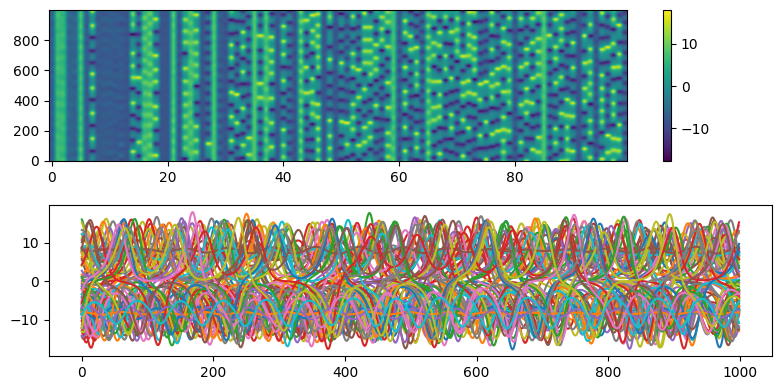

In [117]:
N_end = 1000
fig, axs = plt.subplots(2, 1, figsize=(8, 4))
im1 = axs[0].imshow(mem1, origin="lower", aspect="auto")
fig.colorbar(im1)
fig.tight_layout()

axs[1].plot(mem1[:,:])

plt.show()

#### 加 DLS 

In [118]:
local = np.arange(N)          # 网络学习部位（全部学习）
dls = DLS(N, local, alpha=1.)

# 使用 DLS
mem = []
time = []
Tn = 100_00
for i in range(Tn):
    vj_vi = nodes.vars_nodes[0]-np.expand_dims(nodes.vars_nodes[0], axis=1)   # pre减post
    Isyn = (w*connM*vj_vi).sum(axis=1)
    nodes(Isyn)

    if i % 10 == 0:
        factor = connM*vj_vi
        dls.train(w, factor, nodes.vars_nodes[0], dt=dt)  # dls

    mem.append(nodes.vars_nodes[0].copy())
    mem_all.append(nodes.vars_nodes[0].copy())
    
mem1 = np.array(mem)

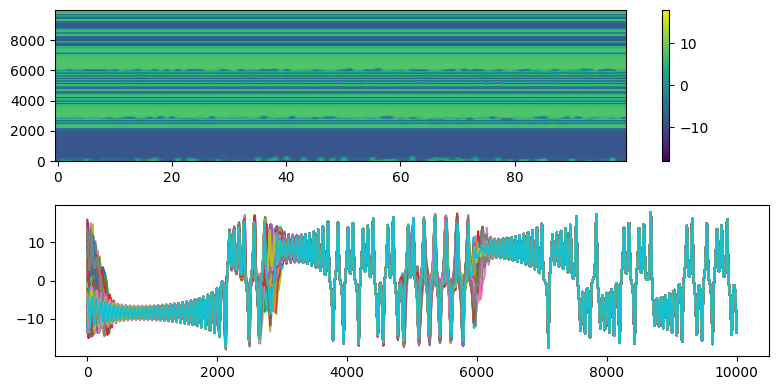

In [119]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4))
im1 = axs[0].imshow(mem1, origin="lower", aspect="auto")
fig.colorbar(im1)
fig.tight_layout()

axs[1].plot(mem1[:,:])

plt.show()

In [120]:
# 计算保存
Tn = 4000
for i in range(Tn):
    vj_vi = nodes.vars_nodes[0]-np.expand_dims(nodes.vars_nodes[0], axis=1)   # pre减post
    Isyn = (w*connM*vj_vi).sum(axis=1)
    nodes(Isyn)
    
    mem_all.append(nodes.vars_nodes[0].copy())

mem1 = np.array(mem)

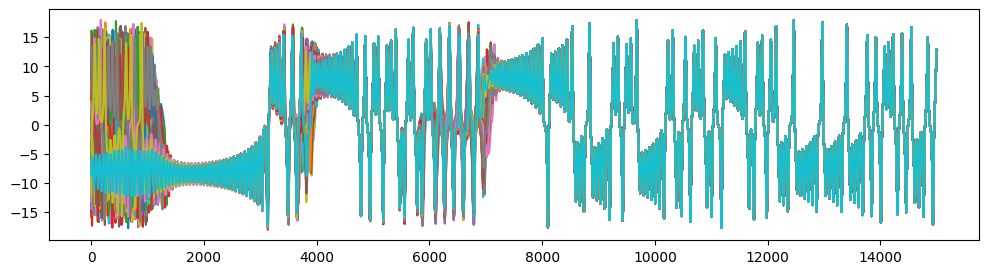

In [121]:
fig, axs = plt.subplots(1, 1, figsize=(12, 3))
axs.plot(mem_all)
plt.show()

In [122]:
# 求解特征值
connM1 = connM*w
degrees = np.sum(connM1, axis=1)
degree_matrix = np.diag(degrees)
# 计算拉普拉斯矩阵
laplacian_matrix = degree_matrix - connM1
eigenvalues = np.linalg.eigvals(laplacian_matrix)
# eigenvalues.real
# eigenvalues
eigenvalues_pre = np.sort(eigenvalues.real)
print(eigenvalues_pre[1], eigenvalues_pre[-1])

10.682268890831665 81.75374974962287
